# waLBerla Tutorial 01: Basic data structures

## Preface

This is an interactive Python notebook. The grey cells contain runnable Python code which can be executed with *Ctrl+Enter*. Make sure to execute all of them in the right order, since they built upon each other. You can also execute them all in the beginning using *"Cell->Run all"*. To get back to a clean state use *"Kernel->Restart"*.


## Step 1: Game of Life in Python with numpy


This first tutorial introduces waLBerla's basic data structures,
by implementing a version of <a href="http://en.wikipedia.org/wiki/Conway%27s_Game_of_Life" target="_blank">Conway's Game of Life</a> cellular automaton.
The _Game of Life_ algorithm is formulated on a regular grid of cells. Each cell can be in one of two states: _dead_ or _alive_. The time evolution of this game is a simple rule how to get to the next cell state by only using cell states of neighboring cells. For details see <a href="http://en.wikipedia.org/wiki/Conway%27s_Game_of_Life" target="_blank">the Wikipedia page</a>.


Before working with waLBerla we first start with a pure Python implementation of this algorithm using the popular <a href="http://www.numpy.org/">numpy package</a>. If you are not familiar with that package, now is a good time to read up on it.

In [1]:
import numpy as np
def makeGrid(shape):
    return np.zeros(shape, dtype=np.int8)
print(makeGrid( [5,5] ))

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


We have created an empty playing field consisting of 8-bit integer values, all initialized with zeros.
Now we write a function iterating over all cells, applying the update rule on each one of them.  In waLBerla these update functions are called  _sweeps_, since they iterate (sweep) over the complete domain and update each cell separately. A crucial point here is that at each cell, we only have to access neighboring values, and, since we create a new temporary copy, all of these cell updates could in principle happen in parallel.

In [2]:
ALIVE = 1
DEAD  = 0

neighborhoodD2Q9 = [ (i,j) for i in [-1,0,1] 
                           for j in [-1,0,1] 
                           if i != 0 or j!=0 ]

def gameOfLifeSweep(grid):
    temporaryGrid = np.copy(grid)
    for i in range(1, grid.shape[0]-1):
        for j in range(1, grid.shape[1]-1):
            numberOfAliveNeighbors = 0
            for neighborCellOffset in neighborhoodD2Q9:
                ni = i + neighborCellOffset[0]
                nj = j + neighborCellOffset[1]
                if temporaryGrid[ni,nj] == ALIVE:
                    numberOfAliveNeighbors += 1
            if numberOfAliveNeighbors < 2 or numberOfAliveNeighbors > 3:
                grid[i,j] = DEAD
            if numberOfAliveNeighbors == 3:
                grid[i,j] = ALIVE
    return grid     

This code snippet takes a grid and returns the grid in the next timestep. 
For the GameOfLife we use a _D2Q9_ neighborhood, meaning 2 dimensional ( D2 ) with in total 9 cells (Q9). Since we leave out the center (0,0) we strictly speaking have only 8 cells.

In [3]:
print(neighborhoodD2Q9)

[(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]


Lets first initialize a so-called _blinker_ and run a few timesteps

In [4]:
grid = makeGrid( [5,5] )
grid[2,1:4] = ALIVE
print ( "Initial Setup:" )
print ( grid )

for t in range(2):
    grid = gameOfLifeSweep(grid)
    print("After timestep %d: " % (t+1,) )
    print(grid)

Initial Setup:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
After timestep 1: 
[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]]
After timestep 2: 
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


Our implementation seems to work: The blinker is iterating ( blinking ) nicely between these two configurations.

Looking at these configurations in text representation is not a good idea for bigger grids, so lets display our grid using matplotlib. The setup code for matplotlib was put to a separate file called [matplotlib_setup.py](matplotlib_setup.py) which also contains code for creating animations.

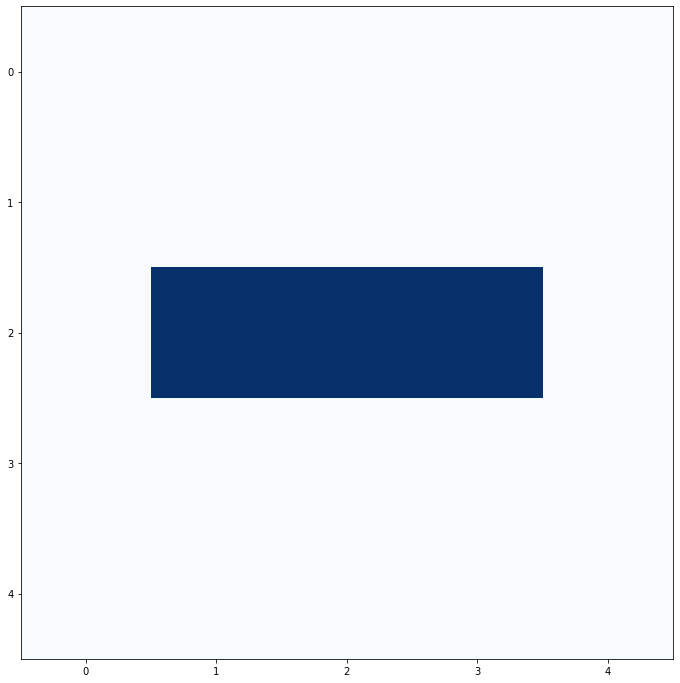

In [5]:
from material.matplotlib_setup import *   # import matplotlib and configures it to play nicely with iPython notebook
matplotlib.rcParams['image.cmap'] = 'Blues' # switch default colormap

im = plt.imshow(grid, interpolation='none')

Now lets create an animation of this blinker:

In [6]:
ani = makeImshowAnimation(grid, gameOfLifeSweep, frames=6)
displayAsHtmlVideo(ani, fps=2)

Now lets load some more interesting starting configuration. Here we choose the 'Gosper Gliding Gun' scenario, taken from Wikipedia.

In [7]:
from imageio import imread
grid = imread('material/GosperGliderGun.png', as_gray=True).astype(int)
grid[grid>0] = ALIVE  # values are from 0 to 255 - set everything nonzero to ALIVE
ani = makeImshowAnimation(grid, gameOfLifeSweep, frames=6*15)
displayAsHtmlVideo(ani, fps=15)

## Step 2: Demonstration with waLBerlas python bindings

waLBerla is parallelized using MPI (message passing interface). That means that multiple processes are started, possibly on different machines which all execute the same program and communicate by sending messages. In a typical Python environment, we would start multiple Python interpreters all executing the same script using `mpirun`. The following command would run a script using four processes:


``` mpirun -np 4 python3 my_waLBerla_script.py```

Using multiple processes is not very convenient in an IPython environment. Thus we only demonstrate here with one process. However, this tutorial can be easily extended to multiple processes

Now lets implement the *Game of Life* algorithm in using waLBerla. waLBerla divides the complete domain into blocks. These blocks can then be distributed to the participating processes. We will set up here a simple example where each process gets one block. waLBerla can put multiple blocks per process. This makes sense if the computational load varies for each block, then a process receives either few expensive blocks or many cheap blocks.

While blocks are the basic unit of load balancing they also act as container for distributed data. In this *Game of Life* example we have to distribute our grid to the blocks e.g. each block internally stores only part of the complete domain. 
The local grids are extended by one ghost layer which are a shadow copy of the outermost layer of the neighboring block.
All these details are handled by waLBerla. 

<img src="material/blocks.png" width="900px"></img>

We only have to specify the number of blocks (which equals the number of processes in our case) and how many cells we want to have on each block. Each of these size informations have to be 3 tuples since waLBerla inherently is a 3D framework. However we can mimic our 2D setup by choosing the size of the z coordinate as 1.

In [8]:
from imageio import imread
import os

# Read the initial scenario
initialConfig = np.rot90( imread('material/GosperGliderGun.png',as_gray=True).astype(int), 3 )
initialConfig[initialConfig>0] = ALIVE  # values are from 0 to 255 - set everything nonzero to ALIVE

In [9]:
# %%px
import sys
import waLBerla as wlb
import numpy as np
import os

# For this tutorial we use only one process. The code can easaly run with more processes and mpirun as pyhton script
numberOfProcesses = 1

domainSize = (initialConfig.shape[0], initialConfig.shape[1], 1)

# We can either specify the detailed domain partitioning ...
blocks = wlb.createUniformBlockGrid(blocks=(numberOfProcesses, 1, 1),
                                    cellsPerBlock=(domainSize[0]//numberOfProcesses, domainSize[1], domainSize[2]),
                                    periodic=(1,1,1))


# Now put one field (i.e. grid) on each block
wlb.field.addToStorage(blocks, name='PlayingField', dtype=np.int32, ghostLayers=1)

# Iterate over local blocks - in our setup we have exactly one block per process - but lets be general
for block in blocks:
    offsetInGlobalDomain = blocks.transformLocalToGlobal(block, wlb.Cell(0,0,0))
    myRank = wlb.mpi.rank()
    print("Block on rank %d: with offset %s" % (myRank, offsetInGlobalDomain[:] ))

Block on rank 0: with offset (0, 0, 0)


Having a distributed domain, we can now run the stencil algorithm locally on each block. We can safely do this, since the simulation domain was extended with one ghost layer. After each sweep over the domain the ghost layers have to be synchronized again. 

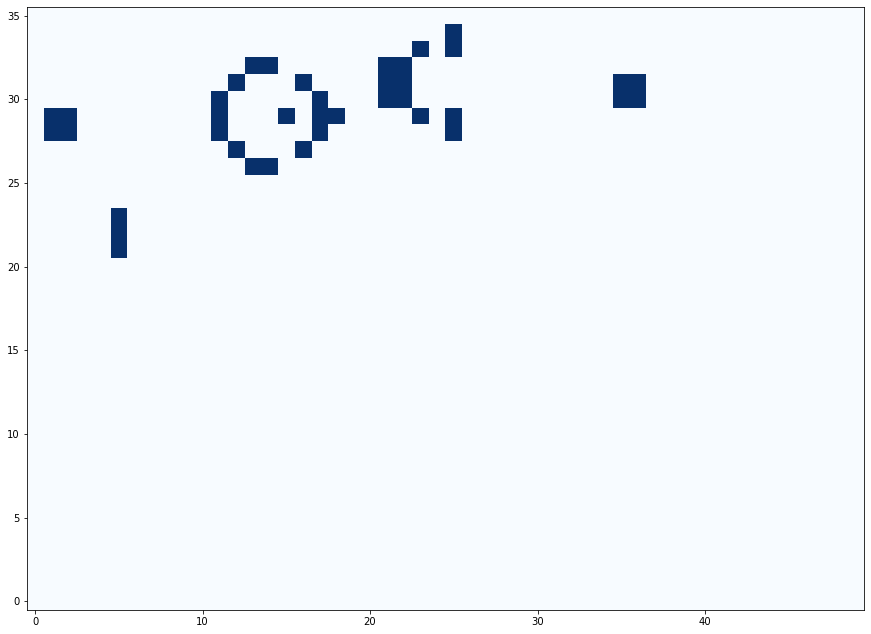

In [10]:
import waLBerla.plot as wlbPlt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from material.matplotlib_setup import *

matplotlib.rcParams['image.cmap'] = 'Blues' # switch default colormap

# Initialize our grid
for block in blocks:
    grid = wlb.field.toArray( block['PlayingField'] ).squeeze()
    offsetInGlobalDomain = blocks.transformLocalToGlobal(block, wlb.Cell(0,0,0))
    blockSize = grid.shape[:2]
    xBegin, xEnd = offsetInGlobalDomain[0], offsetInGlobalDomain[0] + grid.shape[0]
    yBegin, yEnd = offsetInGlobalDomain[1], offsetInGlobalDomain[1] + grid.shape[1]
    grid[:,:] = initialConfig[xBegin:xEnd, yBegin:yEnd]

wlbPlt.scalar_field( blocks, 'PlayingField', wlb.makeSlice[:,:,0] )

In [11]:
communication = wlb.createUniformBufferedScheme( blocks, 'D2Q9')
communication.addDataToCommunicate( wlb.field.createPackInfo( blocks, 'PlayingField') )

def runTimestep():
    communication()
    for block in blocks:
        grid = wlb.field.toArray( block['PlayingField'], with_ghost_layers=True )[:, :, 1]
        gameOfLifeSweep( grid )
        

ani = wlbPlt.scalar_field_animation( blocks, 'PlayingField', wlb.makeSlice[:,:,0], run_function=runTimestep, frames=100 )
displayAsHtmlVideo( ani, fps=30, show=(wlb.mpi.rank()==0) )